In [41]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Conv2D, MaxPooling2D, Dense
from keras.callbacks import TensorBoard

In [35]:
import os
from sklearn.model_selection import train_test_split
from shutil import copyfile

train_folder = "/kaggle/working/train_data"
train_set_folder = "/kaggle/working/train_set"
val_set_folder = "/kaggle/working/val_set"

class_folders = [f.path for f in os.scandir(train_folder) if f.is_dir()]

for class_folder in class_folders:
    class_name = os.path.basename(class_folder)
    images = [f.path for f in os.scandir(class_folder) if f.is_file()]
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    for image in train_images:
        dest_folder = os.path.join(train_set_folder, class_name)
        os.makedirs(dest_folder, exist_ok=True)
        copyfile(image, os.path.join(dest_folder, os.path.basename(image)))

    for image in val_images:
        dest_folder = os.path.join(val_set_folder, class_name)
        os.makedirs(dest_folder, exist_ok=True)
        copyfile(image, os.path.join(dest_folder, os.path.basename(image)))



In [19]:
image_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

image_gen.flow_from_directory("./train_data")


cv2.imread(image_gen.flow_from_directory("./train_data")[0])

Found 9990 images belonging to 10 classes.
Found 9990 images belonging to 10 classes.


TypeError: Can't convert object to 'str' for 'filename'

In [ ]:
### Custom model using CNN ###

model = Sequential()

input_shape = (150, 150, 3)

# add convolution layers
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=input_shape, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=input_shape, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=input_shape, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

# add flatten
model.add(Flatten())

# add dense layers
model.add(Dense(128, activation="sigmoid"))

# add drop out layer to help reduce over fitting by randomly turning neurons off during training
# model.add(Dropout(0.5))

# output layer
model.add(Dense(10, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# model summary
model.summary()

batch_size = 16
train_img_gen = image_gen.flow_from_directory("./train_data", target_size=input_shape[:2], batch_size=batch_size)

# class indices
print(train_img_gen.class_indices)

# fit the model
results = model.fit(train_img_gen, epochs=80, steps_per_epoch=600)


Found 7990 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Epoch 1/10


2023-11-06 17:07:57.325640: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


249/249 [==============================] - 26s 98ms/step - loss: 1.9543 - accuracy: 0.3717 - val_loss: 1.6435 - val_accuracy: 0.4491
Epoch 2/10
249/249 [==============================] - 24s 97ms/step - loss: 1.3089 - accuracy: 0.5616 - val_loss: 1.6437 - val_accuracy: 0.4572
Epoch 3/10
249/249 [==============================] - 24s 96ms/step - loss: 1.0195 - accuracy: 0.6646 - val_loss: 1.6038 - val_accuracy: 0.4859
Epoch 4/10
249/249 [==============================] - 24s 96ms/step - loss: 0.8009 - accuracy: 0.7370 - val_loss: 1.6374 - val_accuracy: 0.4884
Epoch 5/10
249/249 [==============================] - 24s 96ms/step - loss: 0.6209 - accuracy: 0.7978 - val_loss: 1.7059 - val_accuracy: 0.4960
Epoch 6/10
249/249 [==============================] - 24s 97ms/step - loss: 0.4952 - accuracy: 0.8361 - val_loss: 1.7856 - val_accuracy: 0.5141
Epoch 7/10
249/249 [==============================] - 24s 96ms/step - loss: 0.4187 - accuracy: 0.8619 - val_loss: 2.0251 - val_accuracy: 0.4814
Epo

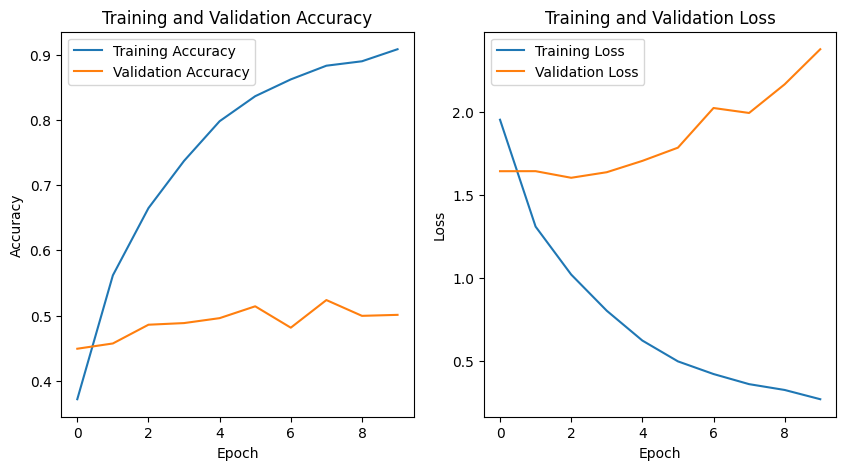

In [55]:
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Flatten

### VGG16 model ### 

# Set the image size and number of classes
img_width, img_height = 224, 224
num_classes = 10

# Set up the data generators for training and validation
train_data_dir = './train_set/'
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1.0/255.0)
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

val_data_dir = './val_set'
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')


# Load the pre-trained VGG16 model without the top layers
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(img_width, img_height, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Build a new model on top of the pre-trained VGG16 model
model = Sequential()
model.add(base_model)
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


log_dir = './logs' 
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model
epochs = 10
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs= epochs,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size)

# Save the trained model
model.save('image_classifier.h5')

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

In [9]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

### ResNet50 model ### 

image_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data_dir = './train_data'
image_gen.flow_from_directory(train_data_dir)


# Load the ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model and add the base ResNet50 model and additional layers
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

train_img_gen = image_gen.flow_from_directory("./train_data", target_size=input_shape[:2], batch_size=64)
# Train the model
model.fit(train_img_gen, batch_size=64, epochs=10, )

# Evaluate the model
# score = model.evaluate(x_test, y_test, verbose=0)


Found 9990 images belonging to 10 classes.
94765736/94765736 [==============================] - 1s 0us/step


/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


NameError: name 'input_shape' is not defined